## Импорт библиотек и загрузка данных

In [2]:
# Установка библиотек

!pip install streamlit -q
!pip install streamlit_folium -q

^C


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Python311\\etc'
Consider using the `--user` option or check the permissions.



In [2]:
# Импорт библиотек
from math import sqrt

import joblib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import streamlit as st
from joblib import dump
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Скачиваем необходимые данные с Google Drive

In [3]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=12UNNxWzKJ0RmQxaQp3acMHvXl7pKWv-N' -O main_data.csv -q

In [4]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=14ne2AonyniucWxIgliHnsjAIULJoo2xl' -O app.py -q

In [5]:
# Загрузка данных

df = pd.read_csv('main_data.csv')

df.head()

,region,address,price,total_area,kitchen_area,living_area,rooms_count,floor,floors_number,build_date,...,longitude,latitude,passenger_elevator,cargo_elevator,metro,metro_distance,metro_transport,district,is_apartments,is_auction
0,msk,"Москва, Большой Толмачёвский переулок",1996610000,459.4,81.4,173.3,5.0,7,8,NaN,...,37.620949,55.739757,1.0,1.0,"Полянка,Новокузнецкая,Третьяковская","6,10,4","walk,walk,transport","Якиманка,ЦАО",0.0,0
1,msk,"Москва, Самотечная ул., 5",66970000,160.0,25.0,119.0,3.0,3,9,1892.0,...,37.618318,55.775165,1.0,1.0,"Цветной бульвар,Достоевская,Сухаревская","6,9,13","walk,walk,walk","Тверской,ЦАО",NaN,1
2,msk,"Москва, Ильинка",378820000,157.4,41.1,50.7,3.0,3,5,NaN,...,37.623649,55.755140,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0
3,msk,"Москва, М. Бронная ул., 32",110500000,110.5,15.0,61.0,3.0,2,6,1912.0,...,37.593524,55.764197,1.0,0.0,"Маяковская,Пушкинская,Тверская","10,10,10","walk,walk,walk","Пресненский,ЦАО",NaN,1
4,msk,"Москва, Ильинка",1031300000,271.8,57.1,123.8,5.0,5,5,NaN,...,37.623509,55.755201,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0


## Анализ данных

In [6]:
# Размер датафрейма

df.shape

(5978, 26)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5248 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5371 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             1405 non-null   float64
 16  longit

In [8]:
# Явные дубликаты

df.duplicated().sum()

0

In [9]:
# Количество пропущенных значений

sorted(df.isna().sum().items(), key=lambda x: x[1])

[('region', 0),
 ('address', 0),
 ('price', 0),
 ('total_area', 0),
 ('floor', 0),
 ('floors_number', 0),
 ('longitude', 0),
 ('latitude', 0),
 ('is_auction', 0),
 ('district', 17),
 ('house_material', 607),
 ('rooms_count', 730),
 ('metro', 874),
 ('metro_distance', 874),
 ('metro_transport', 874),
 ('is_apartments', 938),
 ('complitation_year', 2109),
 ('living_area', 2144),
 ('isСomplete', 2181),
 ('kitchen_area', 2276),
 ('passenger_elevator', 2724),
 ('cargo_elevator', 3285),
 ('build_date', 4481),
 ('parking', 4546),
 ('balcony', 4573),
 ('decoration', 4756)]

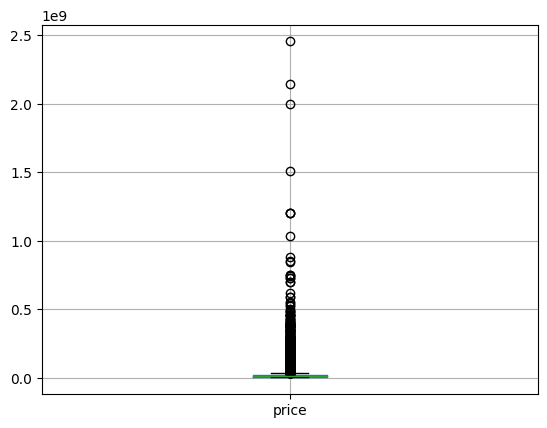

In [10]:
# Изучим целевую переменную

df.boxplot('price');

In [11]:
# Обрежем выбросы - оставим только те значения, что попадают в квантиль 0.90

df = df[df.price < df.price.quantile(q=0.90)]
df.shape

(5380, 26)

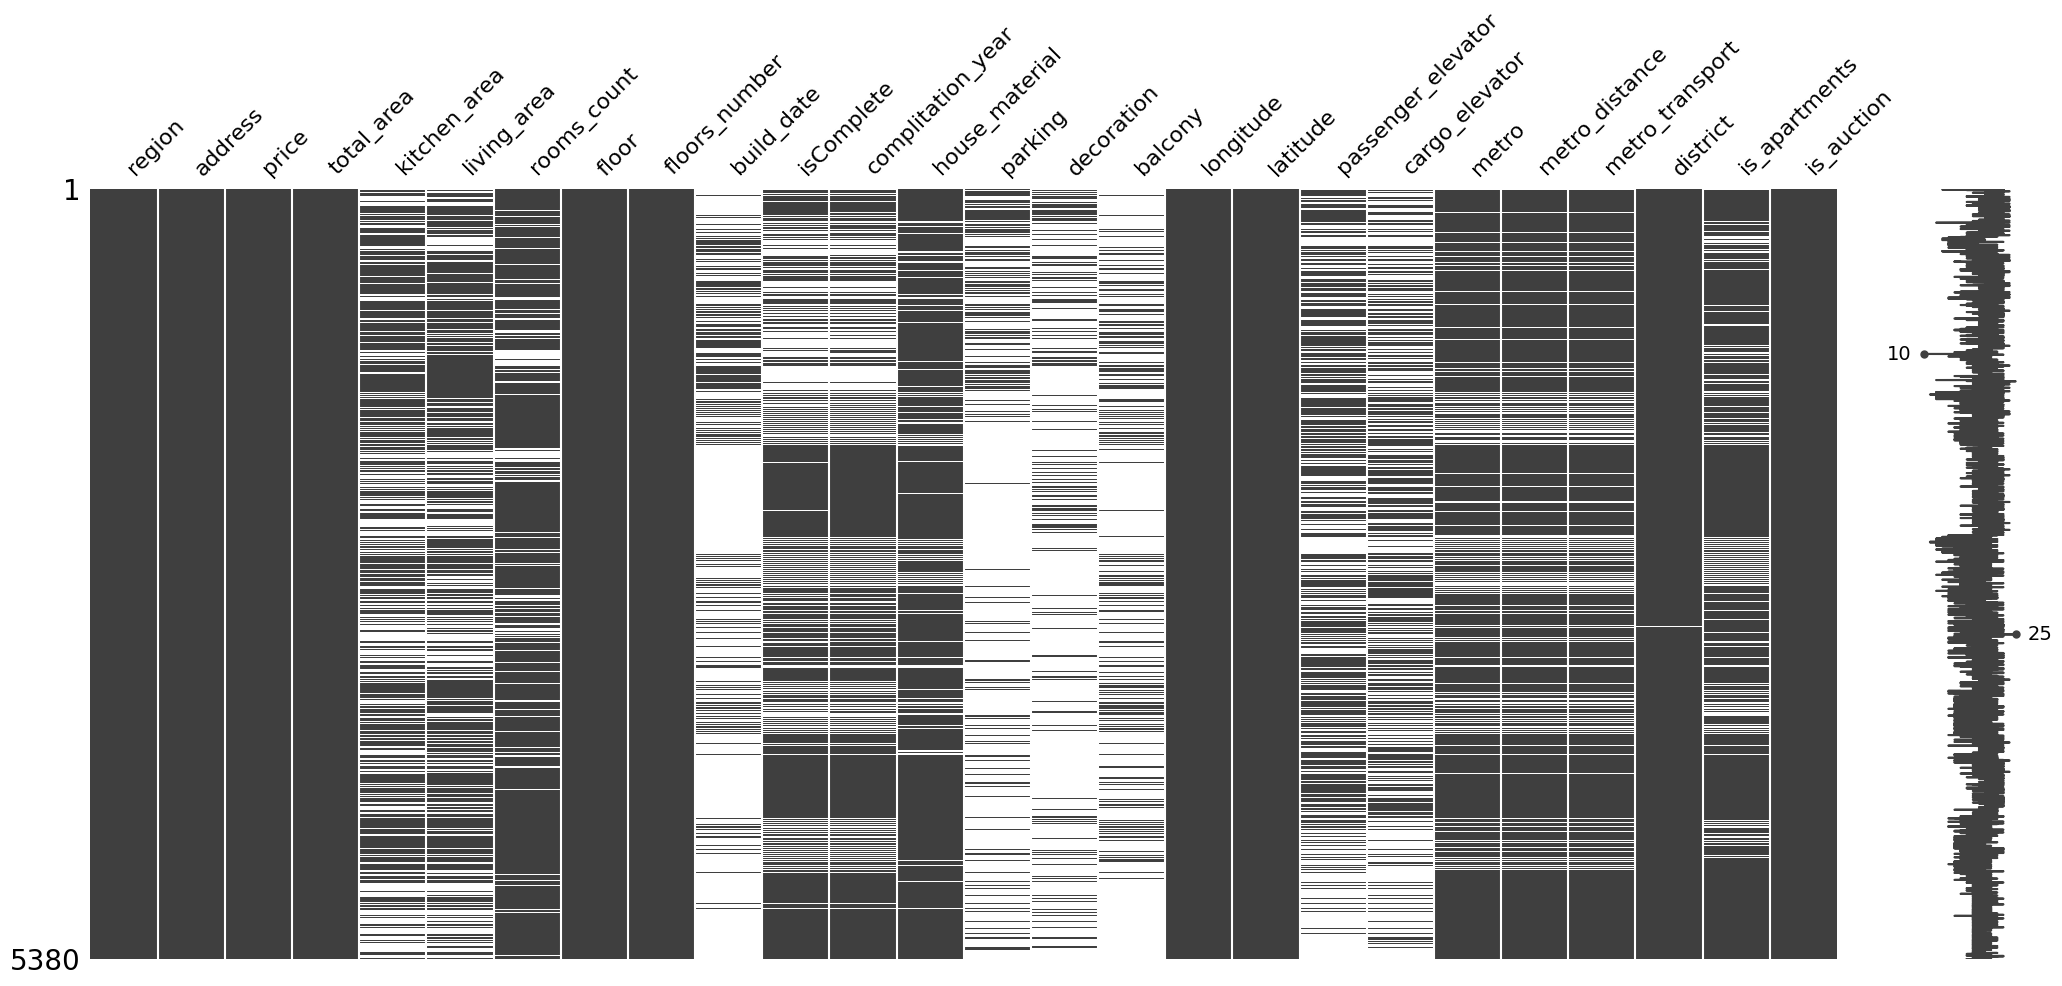

In [12]:
msno.matrix(df)
plt.show()

<ipython-input-13-10b83f3518e0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


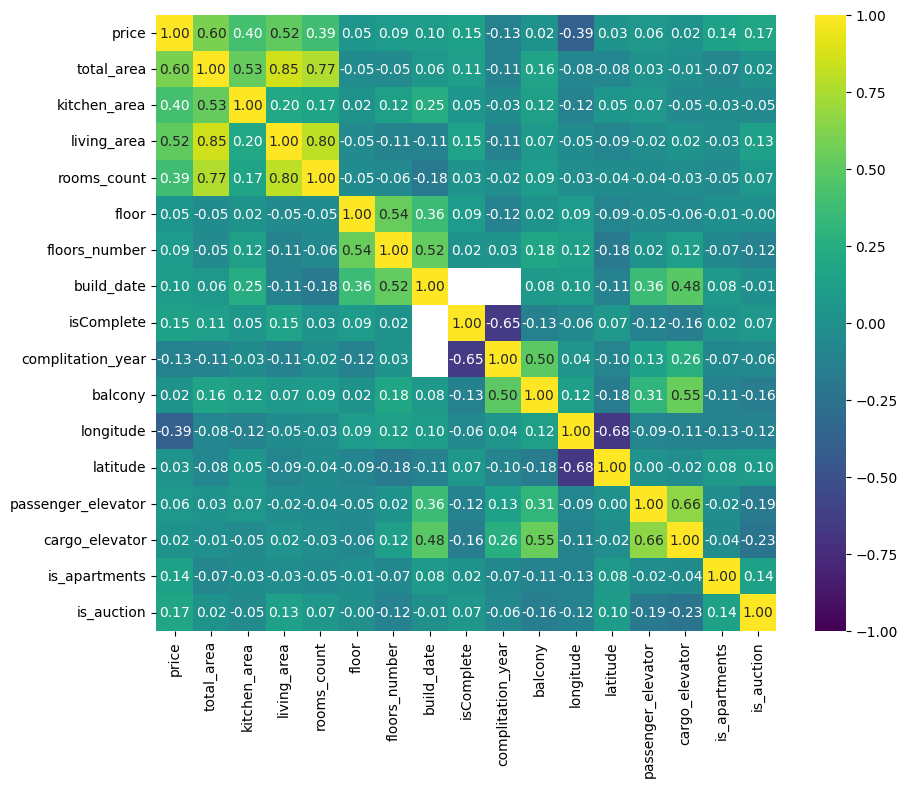

In [13]:
# Вычисление корреляционной матрицы

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f")
plt.show()

In [14]:
# Создание столбца "construction_year" из "build_date" или "complitation_year" и удаление старых столбцов

df['construction_year'] = df['build_date'].combine_first(df['complitation_year'])
df = df.drop(['build_date', 'complitation_year'], axis=1)

In [15]:
# Заполнение пропущенных значений в столбце 'isСomplete' на основе значений в столбце 'construction_year'

df['isСomplete'] = df.apply(lambda row: 0 if pd.isnull(row['isСomplete']) and row['construction_year'] > 2024 else
                                    1 if pd.isnull(row['isСomplete']) and row['construction_year'] < 2024 else
                                    row['isСomplete'], axis=1)

In [16]:
print("Nan: ", df['isСomplete'].isnull().sum())
print("Nan: ", df['construction_year'].isnull().sum())

Nan:  474
Nan:  449


### Жилая площадь и количество комнат

In [17]:
df = df.drop(['kitchen_area', 'living_area'], axis=1)

In [18]:
# Рассчитываем среднюю площадь для каждого количества комнат

average_areas = {}
for i in range(1, 11):
    total_area_sum = df[df['rooms_count'] == i]['total_area'].sum()
    count = df[df['rooms_count'] == i]['total_area'].count()
    if count > 0:
        average_areas[i] = total_area_sum / count

print("Средняя площадь для квартир с разным количеством комнат:")
for key, value in average_areas.items():
    print(f"{key} комнатная квартира: {value:.2f} кв.м")

Средняя площадь для квартир с разным количеством комнат:
1 комнатная квартира: 40.11 кв.м
2 комнатная квартира: 58.39 кв.м
3 комнатная квартира: 79.45 кв.м
4 комнатная квартира: 109.45 кв.м
5 комнатная квартира: 131.64 кв.м
6 комнатная квартира: 200.88 кв.м


In [19]:
# Заполняем пропуски в количестве комнат исходя из средней площади

for index, row in df.iterrows():
    if pd.isnull(row['rooms_count']):
        min_diff = float('inf')
        for key, value in average_areas.items():
            if abs(row['total_area'] - value) < min_diff:
                min_diff = abs(row['total_area'] - value)
                df.at[index, 'rooms_count'] = key

In [20]:
df = df.drop(['parking', 'decoration'], axis=1)

In [21]:
df = df.drop(['passenger_elevator', 'cargo_elevator', 'address', 'metro', 'metro_distance', 'metro_transport', 'is_apartments'], axis=1)

In [22]:
df = df.dropna(subset=['district'])

In [23]:
df = df.dropna(subset=['isСomplete'])

In [24]:
# Рассчитываем самый частый материал в районе

main_material = {}
distr = df['district'].unique()

for i in distr:
    df_i = df[df['district'] == i]
    a = df_i.groupby('house_material')['price'].count()
    for t in a.index:
        if a.max() == a[t]:
            main_material[i] = t

# Заполняем пропуски материала в зависимости от района

for index, row in df.iterrows():
    if pd.isnull(row['house_material']):
        for key, value in main_material.items():
            if row['district'] == key:
                df.at[index, 'house_material'] = value

In [25]:
# Рассчитываем самое частое кол-во балконов в районе

main_material = {}
distr = df['district'].unique()

for i in distr:
    df_i = df[df['district'] == i]
    a = df_i.groupby('balcony')['price'].count()
    for t in a.index:
        if a.max() == a[t]:
            main_material[i] = t

# Заполняем пропуски в зависимости от района и года постройки (у домов младше 2014 явно есть балкон)

for index, row in df.iterrows():
    if pd.isnull(row['balcony']):
        for key, value in main_material.items():
            if row['district'] == key:
                df.at[index, 'balcony'] = value
    if pd.isnull(row['balcony']):
        if row['construction_year'] > 2014:
            df.at[index, 'balcony'] = 1

In [26]:
df.isna().sum()

region                0
price                 0
total_area            0
rooms_count           0
floor                 0
floors_number         0
isСomplete            0
house_material       22
balcony              55
longitude             0
latitude              0
district              0
is_auction            0
construction_year     4
dtype: int64

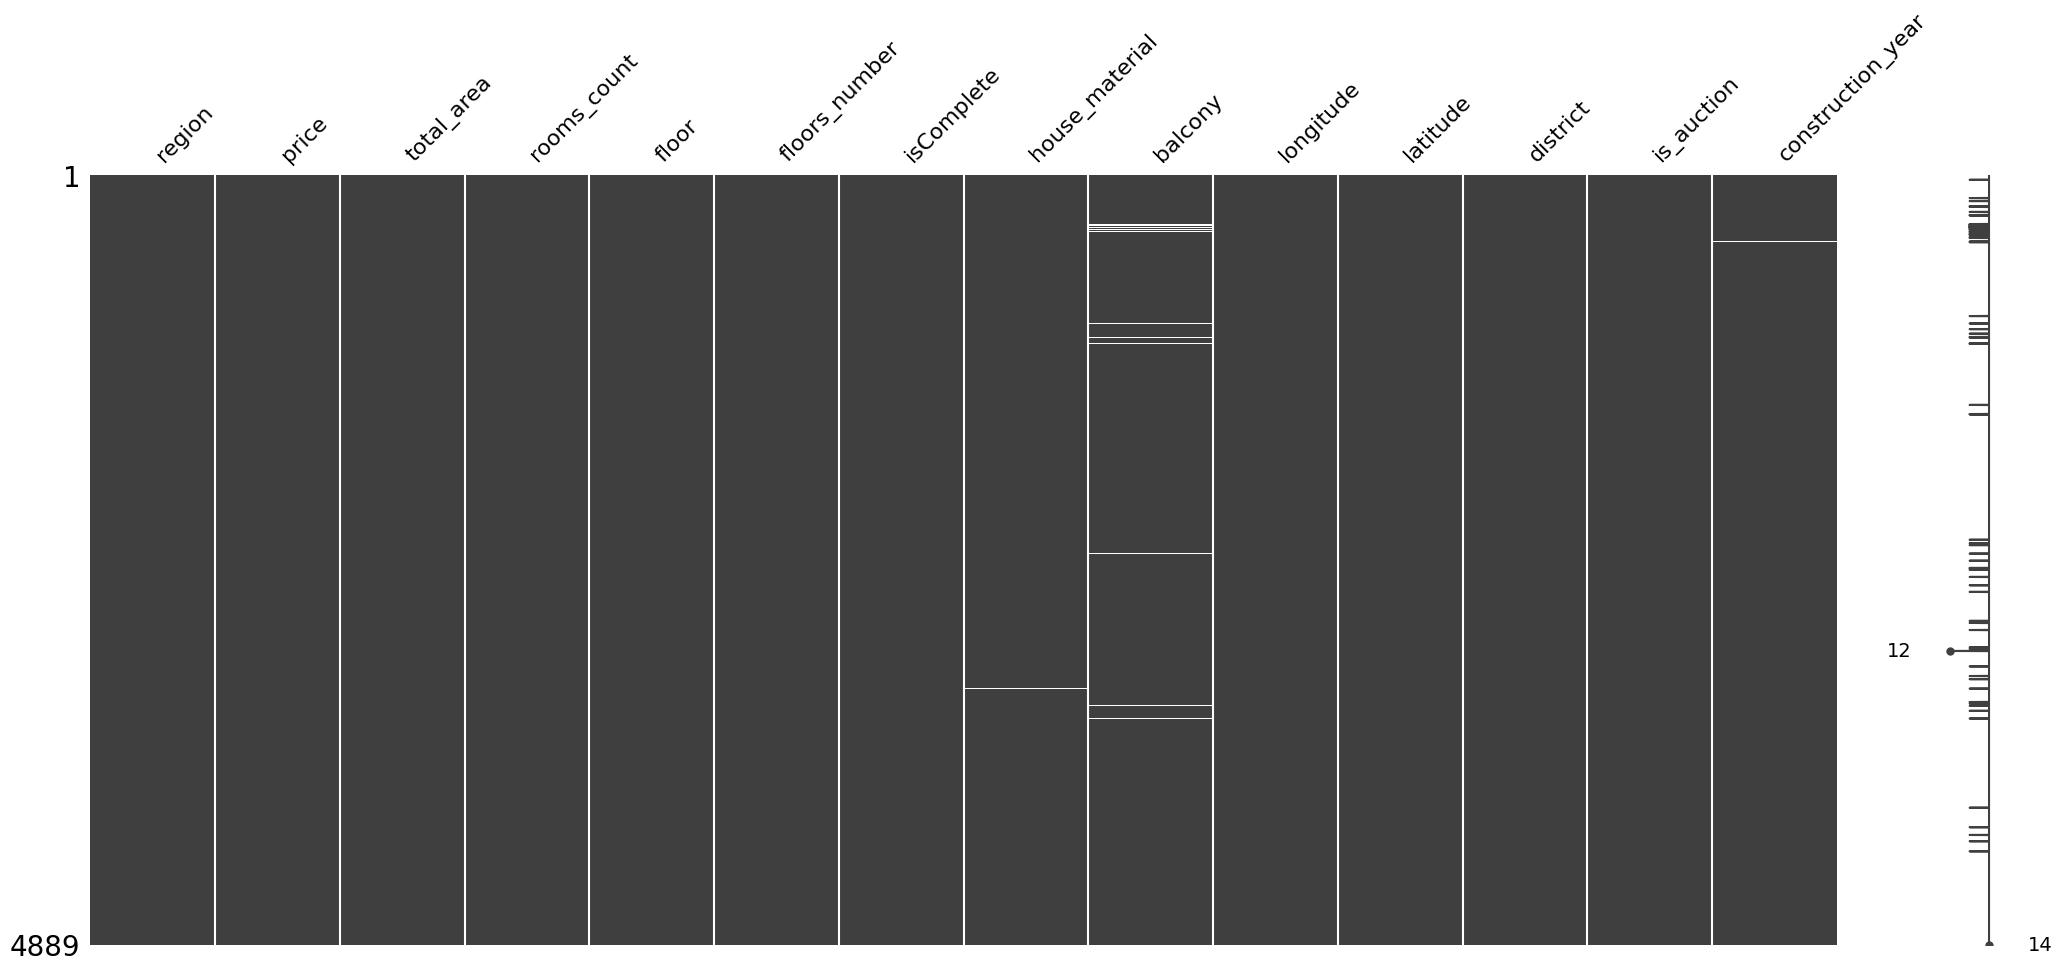

In [27]:
msno.matrix(df)
plt.show()

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'rooms_count'}>],
       [<Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'floors_number'}>,
        <Axes: title={'center': 'isСomplete'}>],
       [<Axes: title={'center': 'balcony'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'is_auction'}>,
        <Axes: title={'center': 'construction_year'}>, <Axes: >]],
      dtype=object)

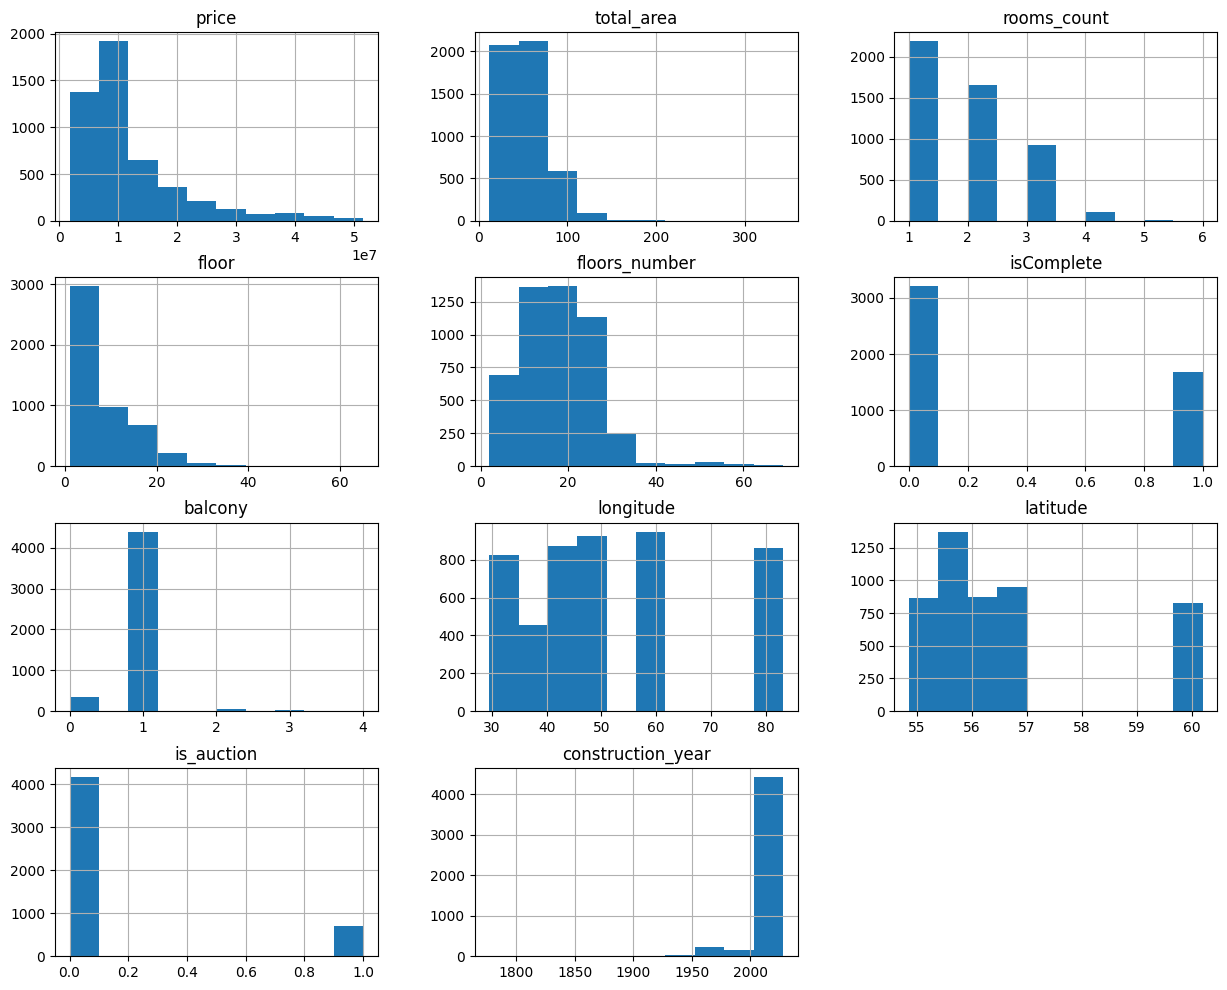

In [28]:
df.hist(figsize=(15,12))

<Axes: xlabel='longitude', ylabel='latitude'>

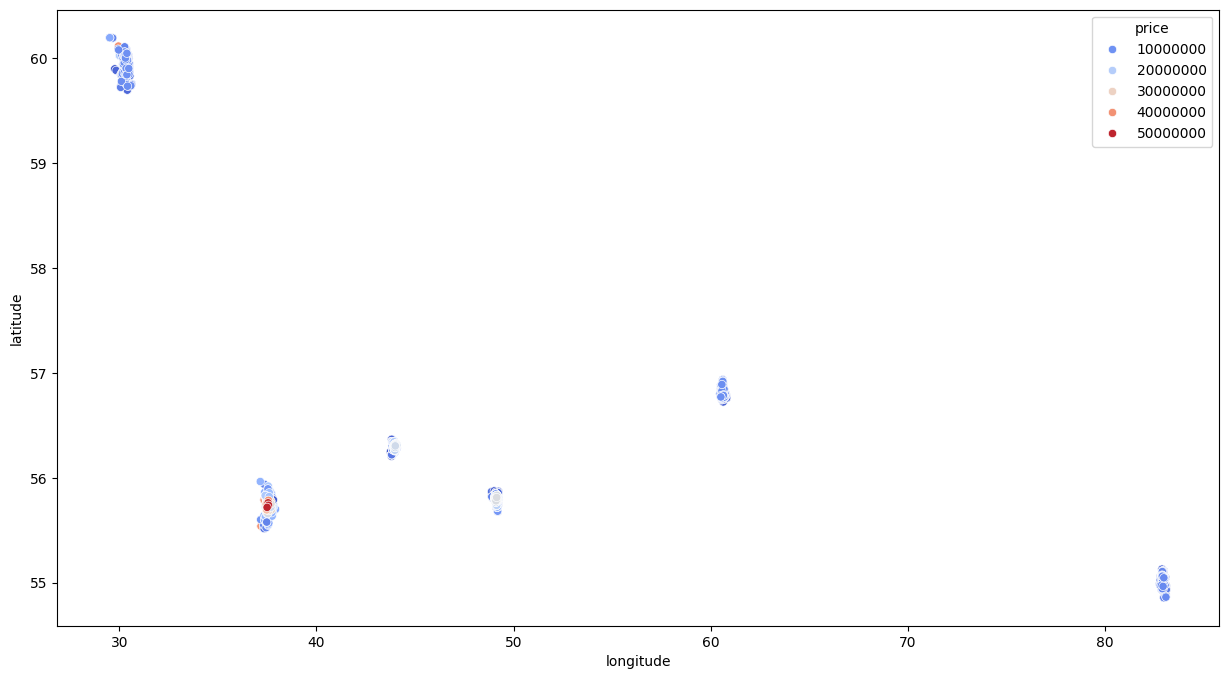

In [29]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='longitude', y='latitude', data = df, hue='price', palette='coolwarm')

In [30]:
import plotly.express as px

# Создаем интерактивную карту
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="price", size="price", zoom=3, mapbox_style="carto-positron", color_continuous_scale=['blue', 'yellow', 'red'])

# Увеличиваем размер маркеров
fig.update_traces(marker=dict(size=10))

# Устанавливаем размер окна карты
fig.update_layout( width=800, height=600)

# Отображаем карту
fig.show()

In [31]:
df['region'].unique()

array(['msk', 'spb', 'ekb', 'nsk', 'kzn', 'nng'], dtype=object)

In [32]:
df = pd.get_dummies(df, columns=['region'])

<ipython-input-33-10b83f3518e0>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



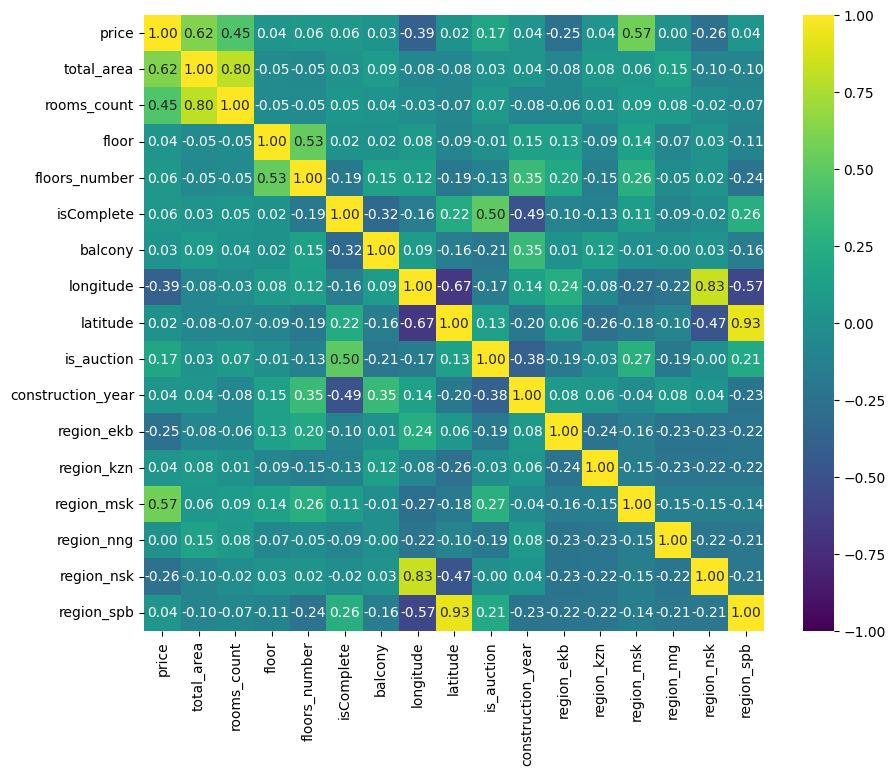

In [33]:
# Вычисление корреляционной матрицы

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f")
plt.show()

In [34]:
df = df.drop(['district'], axis=1)

In [35]:
df["house_material"].unique()

array(['monolith', 'brick', 'monolithBrick', 'panel', 'block', nan, 'old',
       'stalin', 'wood', 'gasSilicateBlock'], dtype=object)

In [36]:
material_mapping = {
    'monolith': 1,
    'brick': 2,
    'monolithBrick': 3,
    'panel': 4,
    'block': 5,
    'nan': 6, # Assuming you want to replace NaN with a number
    'old': 7,
    'stalin': 8,
    'wood': 9,
    'gasSilicateBlock': 10
}

In [37]:
df['house_material'] = df['house_material'].replace(material_mapping)

In [38]:
df = df.dropna(subset=['house_material'])

In [39]:
df = df.dropna(subset=['balcony'])

In [40]:
df = df.drop(['construction_year', 'isСomplete'], axis=1)

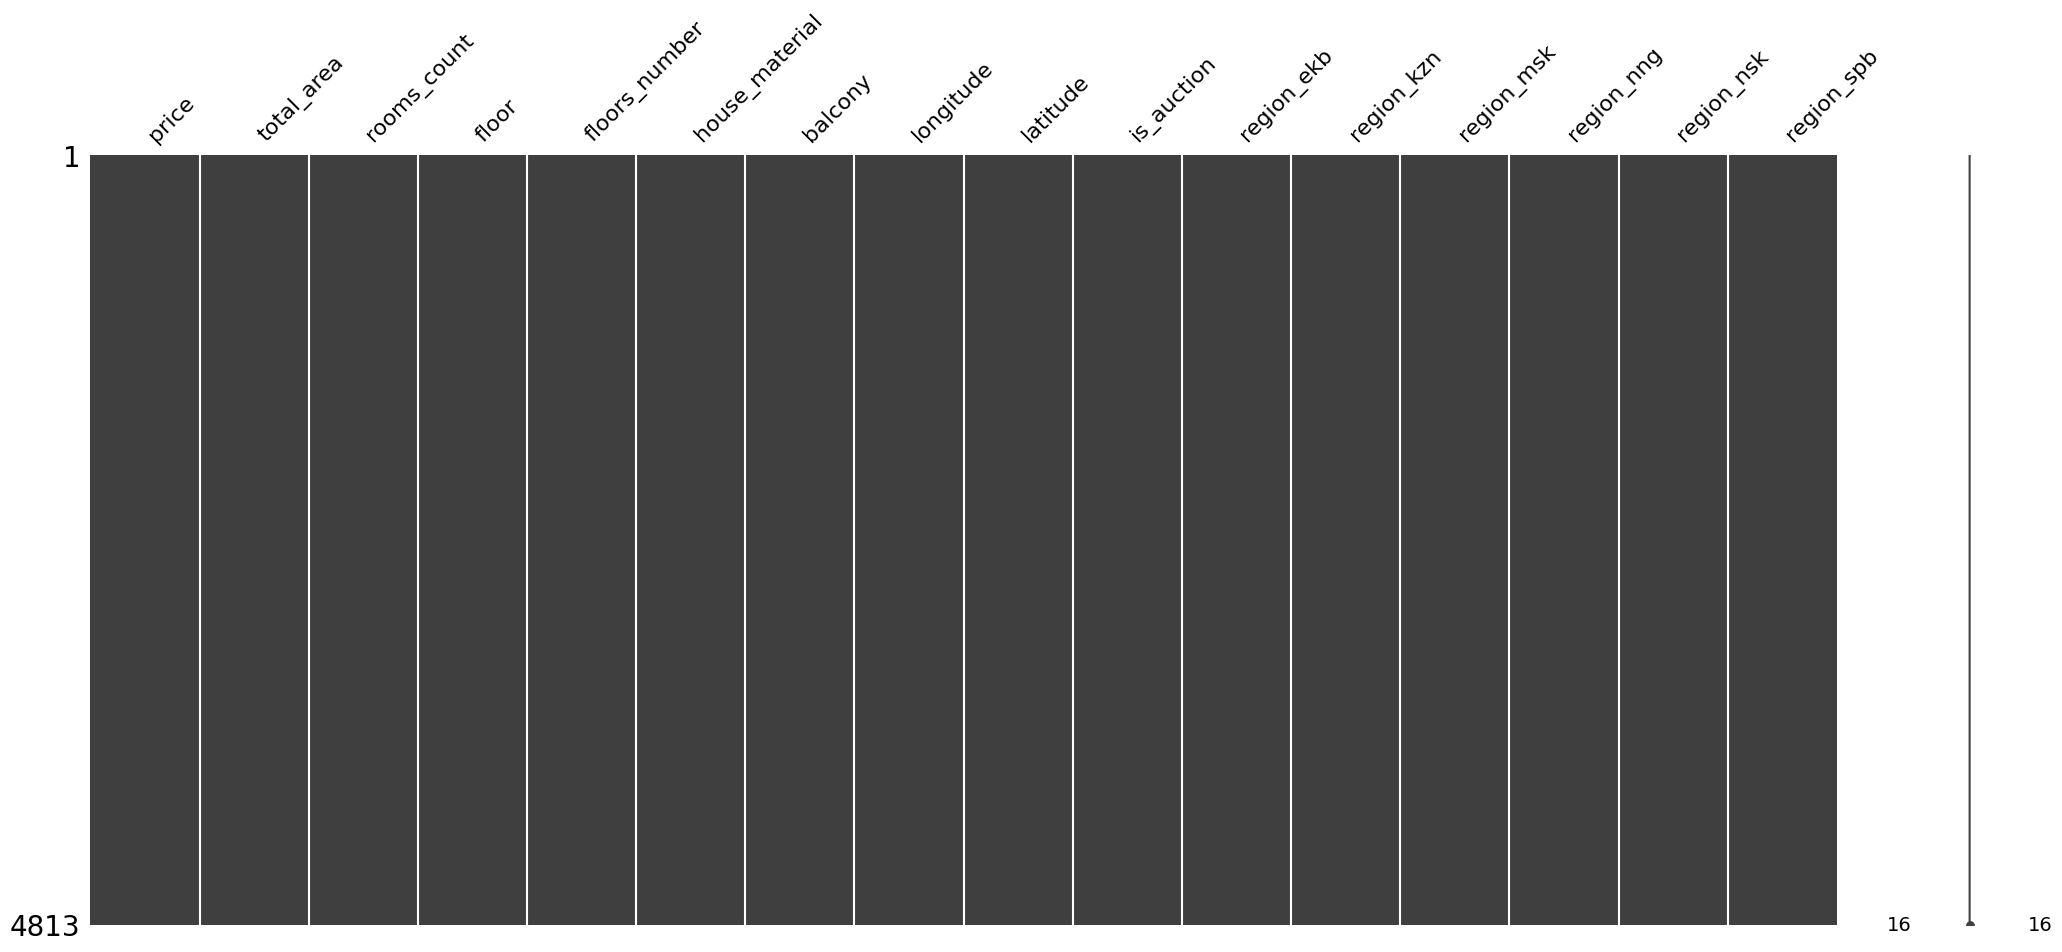

In [41]:
msno.matrix(df)
plt.show()

## Обучение модели

In [42]:
# Разделение данных на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

In [43]:
# Разделение на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Обучение модели Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
# Предсказание на тестовых данных
y_pred_rf = rf.predict(X_test)

In [46]:
# Оценка качества модели Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
print("Коэффициент детерминации Random Forest (R^2):", r2_rf)

Коэффициент детерминации Random Forest (R^2): 0.9064174653745829


In [47]:
import xgboost as xgb

# Инициализация и обучение модели градиентного бустинга
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
predictions_xgb = xgb_model.predict(X_test)

# Оценка качества модели градиентного бустинга
r2_xgb = r2_score(y_test, predictions_xgb)
print("Коэффициент детерминации градиентного бустинга (R^2):", r2_xgb)

Коэффициент детерминации градиентного бустинга (R^2): 0.9151752689681562


In [48]:
# Улучшение гиперпараметров модели градиентного бустинга
xgb_model_tuned = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, colsample_bytree=0.5)
xgb_model_tuned.fit(X_train, y_train)

# Предсказание на тестовой выборке с улучшенными гиперпараметрами
predictions_xgb_tuned = xgb_model_tuned.predict(X_test)

# Оценка качества модели градиентного бустинга с улучшенными гиперпараметрами
r2_xgb_tuned = r2_score(y_test, predictions_xgb_tuned)
print("Коэффициент детерминации градиентного бустинга с улучшенными гиперпараметрами (R^2):", r2_xgb_tuned)

Коэффициент детерминации градиентного бустинга с улучшенными гиперпараметрами (R^2): 0.9205309590928614


In [49]:
dump(r2_xgb_tuned, 'model_xgb.joblib')

['model_xgb.joblib']

## Веб-интерфейс

In [67]:
# Запускаем утилиту wget для получения внешнего IP-адреса от сервиса ipv4.icanhazip.com

!wget -q -O - ipv4.icanhazip.com

34.125.82.242


In [114]:
!streamlit run app.py --theme.primaryColor="#8A2BE2" --theme.backgroundColor="#FFFFFF" --theme.secondaryBackgroundColor="#f2f3f4" --theme.textColor="#4B0082" & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.82.242:8501

npx: installed 22 in 3.625s
your url is: https://tiny-jars-notice.loca.lt
  Stopping...
^C
